In [ ]:
# Standard library imports
import os
from collections import Counter

# Third party imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.io import arff

# Machine Learning Libraries
import sklearn
from sklearn.datasets import load_iris, load_breast_cancer
from sklearn.decomposition import PCA, KernelPCA
from sklearn.metrics import (ConfusionMatrixDisplay, confusion_matrix, f1_score,
                             accuracy_score, precision_score, recall_score,
                             precision_recall_curve, classification_report,
                             roc_curve, auc, roc_auc_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# YData profiling
# !pip install -q ydata_profiling
# from ydata_profiling import ProfileReport

# Global instance of StandardScaler
scaler = StandardScaler()


In [ ]:
# For working in google_colab
from google.colab import drive
drive.mount('/content/drive')

# Add the folder to your google drive account to run it and change the directory path.
# You can also add Datasets to try it.
# LINK of Datasets: https://drive.google.com/drive/folders/12K1jIqNfU_yVOSdn_pqOX9kIVAgLRFPg?usp=sharing

Mounted at /content/drive


In [ ]:
import os
# Save all datasets
directory_path = "/content/drive/MyDrive/KPCA_PCA/datasets/"
dataset_ex = ['.csv', '.data', '.mat', '.xls' ]
datasets = [f for f in os.listdir(directory_path)]# if ( f.endswith('.data') or f.endswith('.csv') or f.endswith('.mat') or f.endswith('.xls')) and f not in dataset_ex]
datasets

['HTRU_2.csv',
 'lymphography.data',
 'musk.mat',
 'cardio.mat',
 'mnist.mat',
 'bupa.data',
 'perfume_data.xlsx',
 'badges.data',
 'vowel-context.data',
 'arrhythmia.data',
 'vowel.tr-orig-order',
 'doccc.xls',
 'thyroid',
 'cancer.csv',
 'annthyroid_21feat_normalised.csv',
 'vowels']

In [ ]:
#read dataset and set the name of the columns
def vowelData ():
    name = 'vowel'

    vowel = arff.loadarff(directory_path+"vowels")

    vowel_data = pd.DataFrame(vowel[0])
    vowel_data.columns = ['feature{}'.format(i) for i in range(0,vowel_data.shape[1])]

    vowel_data = vowel_data.drop_duplicates()
    vowel_data.reset_index(drop=True,inplace=True)

    mappings = {}
    count = 0
    for i in list(Counter(vowel_data['feature12']).keys()):
        mappings[i] = count
        count = count +1

    mappings_users = {}
    count_users = 0
    for i in list(Counter(vowel_data['feature0']).keys()):
        mappings_users[i] = count_users
        count_users = count_users +1

    vowel_data.feature12 = vowel_data.feature12.fillna('nan').apply(lambda x: mappings[x])
    vowel_data.feature0 = vowel_data.feature0.fillna('nan').apply(lambda x: mappings_users[x])
    vowel_data.feature1 = vowel_data.feature1.fillna('nan').apply(lambda x: {b'Male':0,b'Female':1}[x])

    return vowel_data, vowel_data.drop(columns='feature12'),vowel_data.feature12

In [ ]:
def irisData ():
    name = 'iris'
    iris = load_iris()


    iris_dataset = pd.DataFrame(data=iris, columns=iris.feature_names)

    iris_dataset = iris_dataset.drop_duplicates()
    iris_dataset.reset_index(drop=True,inplace=True)

    iris_dataset.columns = ['feature{}'.format(i) for i in range(0,iris_dataset.shape[1])]

    dataset = pd.DataFrame(iris.data).assign(target=iris.target)

    return dataset, iris.data, iris.target

In [ ]:
def breastcancerData():
    name = 'breast_cancer'
    breast_cancer = load_breast_cancer()
    breast_cancerData = pd.DataFrame(data=breast_cancer, columns=breast_cancer.feature_names)

    breast_cancerData = breast_cancerData.drop_duplicates()
    breast_cancerData.reset_index(drop=True,inplace=True)

    breast_cancerData.columns = ['feature{}'.format(i) for i in range(0,breast_cancerData.shape[1])]

    dataset = pd.DataFrame(breast_cancer.data).assign(target=breast_cancer.target)

    return dataset, breast_cancer.data, breast_cancer.target

In [ ]:
# call one of the function to load the dataset
# df, data ,target = vowelData ()
# df, data ,target = irisData ()
# df, data ,target = breastcancerData()

In [ ]:
def function_AD(model,
                X_train, y_train, X_test, y_test,
                n_components=None,
                kernel='rbf',
                gamma=None,
                degree=3,
                coef0=1,
                contamination=0,
                outlier=0,
                analysis=False):

  # Selection between PCA and KernelPCA
  if model=='pca':

    model_ad = PCA(n_components=None)                                         # Create the model for PCA
    model_ad.fit(X_train,y=None)                                              # Fit the model with the given train-set (the model should contain only the normal class)
    n_components = model_ad.n_components_                                     # The total number of components (For PCA are the number of the features)
    print("The non-0s PCA components are: \n",n_components)
    components = model_ad.components_                                         # The components
    exp_var = model_ad.explained_variance_                                    # Here is the explained variance for each componant
    exp_var_rat = model_ad.explained_variance_ratio_                          # Here is the explained variance ratio for each componant


    plot_explained_variance_AD(exp_var_rat)                                      # Here is the explained variance for each component
    n_components = explained_variance_threshold_AD(exp_var_rat, n_components)    # Select the components tha discribe the 90% of cumulative explained_variance

    # Re-fit the model with the selected components
    if n_components == 1: n_components = 2
    model_ad = PCA(n_components=n_components)

  else:
    if model=='kpca':
      n_components=2


      model_ad = KernelPCA(n_components=n_components, kernel=kernel,          # Create the model
                           gamma=gamma, degree=degree, coef0=coef0, fit_inverse_transform=True)
    else:
      print("The model you can use are PCA and KernelPCA as: pca or kpca respectively")
      return

  # Fit the model with the X_train and transforming the X_train into the selected number of components and then reconstructed.
  X_train_reconstructed = model_ad.inverse_transform(model_ad.fit_transform(X_train))

  # Reduce and reconstruct the test-data back to its original
  X_test_reduced = model_ad.transform(X_test)
  X_test_reconstructed = model_ad.inverse_transform(X_test_reduced)

  # Get the reconstruction Errors
  rec_errors_test = reconstruction_errors_AD(X_test, X_test_reconstructed)
  rec_errors_train = reconstruction_errors_AD(X_train, X_train_reconstructed)

  # Calculate the Novelty Scores
  anom_scores = anomaly_scores_AD(rec_errors_train, rec_errors_test)

  # Threshold
  threshold = threshold_ratio_AD(X_train, y_test, rec_errors_train, outlier=outlier, contamination=contamination, anom_scores = anom_scores)

  # Classify the test data as normal or anomalous based on the reconstruction error and the selected threshold
  y_pred = [1 if e > threshold else 0 for e in rec_errors_test]

  if model=='pca' or analysis==False:

    # Plot the score of anomalies and the threshold
    plot_anomalies_with_threshold_AD(anom_scores, threshold)

    # Set the figure size and color map
    figsize = (9, 8)
    cmap = 'viridis'

    # Plot the true normal classes of the selected X_test into two Principal Components of the transformed Data
    plt.figure(figsize=figsize)
    scatter = plt.scatter(X_test_reduced[:, 0], X_test_reduced[:, 1], c=y_test, cmap=cmap, alpha=0.7, edgecolors='w', linewidth=0.5)
    # plt.colorbar(scatter, label='True')
    plt.grid(True)
    plt.xlabel('Principal Component 1', fontsize=14)
    plt.ylabel('Principal Component 2', fontsize=14)
    plt.title('Scatter Plot of True Classes using First Two Principal Components', fontsize=16)
    # plt.axhline(y=threshold, color='r', linestyle='--')
    plt.show()

    # Plot the predicted normals and the predicted anomalies of the selected X_test into two Principal Components of the transformed Data
    plt.figure(figsize=figsize)
    scatter = plt.scatter(X_test_reduced[:, 0], X_test_reduced[:, 1], c=y_pred, cmap=cmap, alpha=0.7, edgecolors='w', linewidth=0.5)
    # plt.colorbar(scatter, label='Anomaly')
    plt.grid(True)
    plt.xlabel('Principal Component 1', fontsize=14)
    plt.ylabel('Principal Component 2', fontsize=14)
    plt.title('Scatter Plot of Predicted Classes using First Two Principal Components', fontsize=16)
    # plt.axhline(y=threshold, color='r', linestyle='--')
    plt.show()


    # Print informations about the given test-set
    descriptive_stat_threshold_AD(X_test, anom_scores, threshold)

    # Print and Plot all the Metrics
    calculate_metrics_AD(X_test, y_test, anom_scores, y_pred)
    # print(f1_score(y_test, y_pred))

    eval_recall(anom_scores,y_test)

  else:
    # print(model_ad.get_params)
    return calculate_metrics_AD(X_test, y_test, anom_scores, y_pred, plot=False)
    # return roc_auc_score(y_test, anom_scores), f1_score(y_test, y_pred)

def eval_recall(predicted_labels,label_test):
  preds = predicted_labels
  labels = label_test
  #calculate precision and recall
  precision, recall, thresholds = precision_recall_curve(labels, preds)

  #create precision recall curve
  fig, ax = plt.subplots()
  ax.plot(recall, precision, color='purple')

  #add axis labels to plot
  ax.set_title('Precision-Recall Curve')
  ax.set_ylabel('Precision')
  ax.set_xlabel('Recall')

  #display plot
  plt.show()

# Function that calculates the reconstruction errors
def reconstruction_errors_AD(X, X_reconstructed):
  # Calculate the reconstruction error for each data point
  reconstruction_errors = np.mean((X - X_reconstructed) ** 2, axis=1)
  return reconstruction_errors

# Functions that returns the anomaly scores
def anomaly_scores_AD(reconstruction_errors_train, reconstruction_errors_test):
  # Calculate the Novelty Scores for each data point of the test-set
  mean_error = np.mean(reconstruction_errors_train)
  std_error = np.std(reconstruction_errors_train)
  normalized_error_test = (reconstruction_errors_test - mean_error) / std_error
  return np.abs(normalized_error_test)

# Function that returns the threshold
# Here I am not sure if is the correct way but we can find the best threshold for having the best F-1 score if the contamination=0.
# Otherwise we can set it based a given threshold or as a contamination (% of outliers or anomalies in the test set)
def threshold_ratio_AD(X_train, y_true, reconstruction_errors, outlier=0, contamination=0, anom_scores = 0):
  if contamination==-1:

    # Calculate precision and recall for different thresholds
    precision, recall, thresholds = precision_recall_curve(y_true, anom_scores)

    # Calculate the F1 score for each threshold
    f1_scores = 2 * (precision * recall) / (precision + recall)

    # Find the index of the threshold that maximizes the F1 score
    optimal_idx = np.argmax(f1_scores)

    # Get the optimal threshold
    optimal_threshold = thresholds[optimal_idx]
    print("The optimum threshold of the PCA method:", optimal_threshold)
    threshold = optimal_threshold

  elif contamination==0:
    mean_error = np.mean(reconstruction_errors)
    std_error = np.std(reconstruction_errors)
    normalized_error = (reconstruction_errors - mean_error) / std_error
    threshold = mean_error + 2.5 * std_error

  elif contamination>0 and contamination<0.5:
    serr = np.sort(reconstruction_errors)
    threshold = serr[X_train.shape[0]-outlier-1]

  else:
    print("Not correct contamination ratio")

  return threshold

# Function to plot the explained variance ratio
def plot_explained_variance_AD(exp_var_ratio):

  end = len(exp_var_ratio)+1
  plt.figure(figsize=(9, 6))
  plt.plot(range(1, end), exp_var_ratio*100)
  plt.xlabel('Principal Component ')
  plt.ylabel('Explained Variance percentage (%)')
  plt.xticks(range(1, end))
  plt.show()

# Function to plot the explained variance ratio with the selected cumulative %
def explained_variance_threshold_AD(exp_var_ratio, number_components):

  cum_exp_var = np.cumsum(exp_var_ratio) * 100
  end = number_components+1
  plt.bar(range(1, end), exp_var_ratio * 100, align='center', label='Individual explained variance')
  plt.step(range(1, end), cum_exp_var, where='mid', label='Cumulative explained variance', color='red')
  plt.axhline(y=90, color='gray', linestyle='--', linewidth=1)
  plt.text(end, 90, '90%', color='gray', fontsize=10, va='center')
  plt.ylabel('Explained variance percentage (%)')
  plt.xlabel('Principal component')
  plt.legend(loc='best')
  plt.xticks(ticks=range(1, end))
  plt.tight_layout()
  plt.show()
  # The number of components with the pre-selected % of cumulative %
  # Maybe it is better to increase it to 95% instead of 90%
  number_components = np.where(cum_exp_var > 90)[0][0] + 1
  print("Number of principal components needed to explain 90% of variance:", number_components)

  # Returns the number of components
  return number_components

def plot_anomalies_with_threshold_AD(y_scores, threshold):

  plt.hist(y_scores, bins=50)
  plt.axvline(x=threshold, color='red', linestyle='--', linewidth=2)
  plt.text(threshold, max([list(y_scores).count(x) for x in set(y_scores)]),'Threshold', color='red', fontsize=10, va='center')
  plt.title("Histogram with the threshold")
  plt.xlabel('Anomaly score')
  plt.show()
  print("\n")



# Function that gives a table with statistics about the given test-set (Anomaly scores, Avg, count, count%)
def descriptive_stat_threshold_AD(df, pred_score, threshold):

  df = pd.DataFrame(df)
  df['Anomaly_Score'] = pred_score
  df['Group'] = np.where(df['Anomaly_Score']<= threshold, 'Normal', 'Novelty')

  cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
  cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
  stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
  stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
  return (stat)

# Function to plot the Confussion matrix for the given test-set
def conf_matrix_AD(y_true, y_pred, labels=None, title='Confusion Matrix'):

  cm = confusion_matrix(y_true, y_pred, labels=labels)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  fig, ax = plt.subplots(figsize=(7, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(include_values=True, cmap='Blues', ax=ax, xticks_rotation='horizontal')
  ax.set_title(title)
  ax.set_xlabel('Predicted Label')
  ax.set_ylabel('True Label')
  plt.show()
  return cm

# Function that plots the RocCurve for the given test-set
def roccurve_AD(y_true, y_scores):

  fpr, tpr, thresholds = roc_curve(y_true, y_scores)
  auc_score = auc(fpr, tpr)
  # plt.figure(figsize=(7, 6))
  plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.2f})')
  plt.plot([0,1],[0,1],'g--')
  plt.legend()
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title("AUC(ROC curve)")
  plt.grid(color='black', linestyle='-', linewidth=0.5)
  plt.show()
  print("\n")

# Function that Prints and plots a lot of Metrics
def calculate_metrics_AD(X_true, y_true, pred_scores, y_pred, plot=True):

  # Calculate the AUC-ROC
  auc_roc = roc_auc_score(y_true, pred_scores)

  # Calculate the accuracy
  accuracy = accuracy_score(y_true, y_pred)

  # Calculate the precision
  precision = precision_score(y_true, y_pred)

  # Calculate the recall
  recall = recall_score(y_true, y_pred)

  # Calculate the F1 score
  f1 = f1_score(y_true, y_pred)

  if plot==True:
    print('Confusion Matrix:\n')
    # Confusion matrix
    cm = conf_matrix_AD(y_true, y_pred)
    # ROC_Curve
    roccurve_AD(y_true, pred_scores)
    # Print the results
    print(f'AUC-ROC: {auc_roc:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
  else:
    return auc_roc, f1

def split_data(X, y, chosen_class=0, percentage=0.8):
    if chosen_class not in np.unique(y):
        raise ValueError("Chosen class not found in the target variable.")

    # Filter X for the chosen class: y = class
    X_c = X[y == chosen_class]
    y_c = y[y == chosen_class]

    # Randomly shuffle the rows of X_c and y_c
    random_indices = np.random.permutation(len(X_c))
    X_c = X_c[random_indices]
    y_c = y_c[random_indices]

    # Split X_c and y_c into training and testing sets
    train_size = int(percentage * len(X_c))
    X_train = X_c[:train_size]
    y_train = y_c[:train_size]
    X_test_n = X_c[train_size:]
    y_test_n = y_c[train_size:]

    # Filter X for other classes: y != class
    X_new_a = X[y != chosen_class]
    y_new_a = y[y != chosen_class]

    # Randomly select rows from X_new_a and y_new_a to create X_test_a and y_test_a
    select = len(X_test_n)
    random_indices = np.random.choice(len(X_new_a), size=select, replace=False)
    X_test_a = X_new_a[random_indices]
    y_test_a = y_new_a[random_indices]

    # Combine X_test_n, X_test_a, y_test_n, and y_test_a to create X_test and y_test
    X_test = np.concatenate((X_test_n, X_test_a), axis=0)
    y_test = np.concatenate((y_test_n, y_test_a), axis=0)

    return X_train, X_test, X_test_n, X_test_a, y_train, y_test, y_test_n, y_test_a


In [ ]:
# Choose one of the functions to load the dataset

df_, x ,y = irisData ()
# df_, x, y = vowelData()
# df_, x ,y = breastcancerData()
X = scaler.fit_transform(x)

For Iris and BC

In [ ]:
selected_class = 1
# other_class = 1

# ONE VS ALL
y = np.where(y == selected_class, 0, 1)

# # ONE vs ONE
# mask = np.logical_or(y == selected_class, y == other_class)
# X = X[mask]
# y = y[mask]
# y = np.where(y == selected_class, 0, 1)

For Vowel

In [ ]:
classes_to_keep = [1, 2, 5, 6, 7, 9]

mask = np.isin(y, classes_to_keep)
X = X[mask]
y = y[mask]

selected_class = 1
y = np.where(y == selected_class, 0, 1)


In [ ]:
X_train, X_test, X_test_n, X_test_a, y_train, y_test, y_test_n, y_test_a = split_data(X, y, 0, percentage=0.6)
# The created contamination for a model that we are going to train it only with normal chosen class
contamination = 0.00000001

In [ ]:
# # PCA
# function_AD('pca', X_train, y_train, X_test, y_test, contamination=contamination)

# KPCA
function_AD('kpca', X_train, y_train, X_test, y_test, contamination=contamination)

In [ ]:
X_train, X_test, X_test_n, X_test_a, y_train, y_test, y_test_n, y_test_a = split_data(X, y, 0, percentage=0.6)
# The created contamination for a model that we are going to train it only with normal chosen class
contamination = 0.00000001

# Best gamma and number of components// for PCA:
best_auc = 0.0
best_f1 = 0.0
optimum_gamma = 0.0
optimum_kernel = ''
optimum_n_components = 0

kernels = ['rbf', 'poly']

midpoint = np.log10(0.0833)
gammas = np.logspace(midpoint-2, midpoint+2, num=1000, base=10)
nn_components = [2]

# Initialize dictionaries for storing scores
f1_scores = {}
auc_scores = {}

error_counter = 0 # Counter for continuous errors
for k,kernel in enumerate(kernels):
    for i, n_components in enumerate(nn_components):
        for j, gamma in enumerate(gammas):
            try:
                new_auc, new_f1 = function_AD('kpca', X_train, y_train, X_test, y_test,
                                              n_components=n_components,
                                              analysis=True,
                                              kernel=kernel,
                                              gamma=gamma,
                                              contamination=contamination
                                              )
                # Save scores in the dictionaries
                f1_scores[(kernel, n_components, gamma)] = new_f1
                auc_scores[(kernel, n_components, gamma)] = new_auc

                if new_f1 > best_f1:
                    print("\n=========\n Better F1: ", new_f1,"\n=============")
                    best_auc = new_auc
                    best_f1 = new_f1
                    optimum_gamma = gamma
                    optimum_kernel = kernel
                    optimum_n_components = n_components

                error_counter = 0  # Reset error counter after successful execution

            except Exception as e:
                print(f"An error occurred when calculating scores for kernel={kernel}, n_components={n_components} and gamma={gamma}: {e}")
                error_counter += 1  # Increment error counter

                if error_counter >= 1:  # If 10 continuous errors occur, stop execution
                    print("Too many continuous errors. Stopping execution.")
                    print("===============================================\n")
                    break

        if error_counter >= 1:  # Break the outer loops if needed
            break
    if error_counter >= 1:  # Break the outermost loop if needed
        break

print("Best AUC: ", best_auc)
print("Best F1: ", best_f1)
print("Optimum Kernel: ", optimum_kernel)
print("Optimum Number of Components: ", optimum_n_components)
print("Optimum Gamma: ", optimum_gamma)

function_AD('kpca', X_train, y_train, X_test, y_test,
                                              n_components=2,
                                              kernel=optimum_kernel,
                                              gamma=optimum_gamma,
                                              contamination=contamination
                                              )


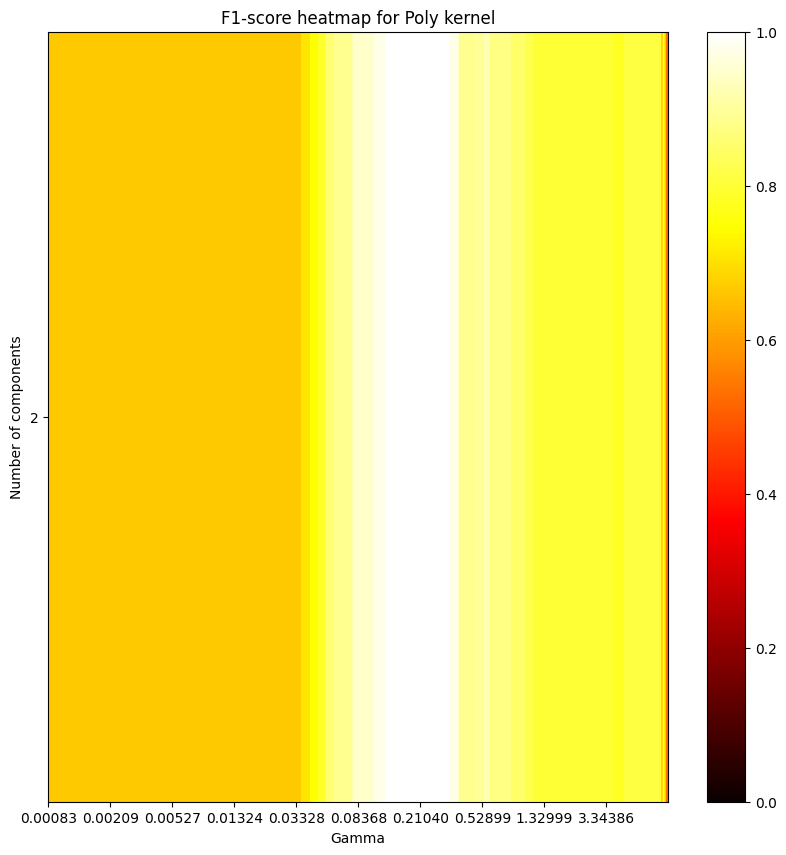

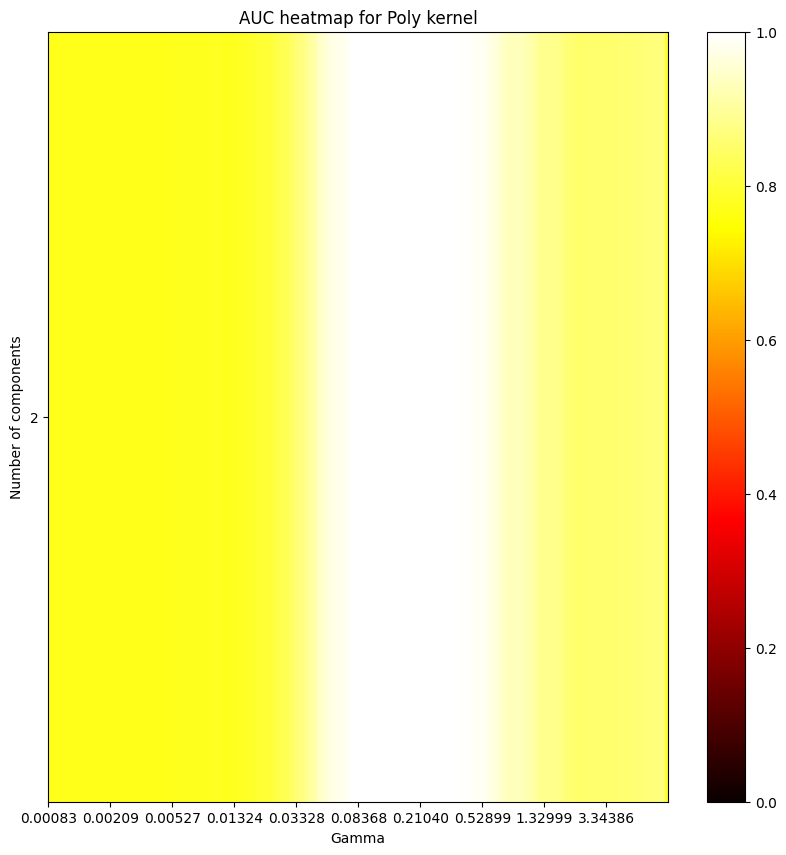

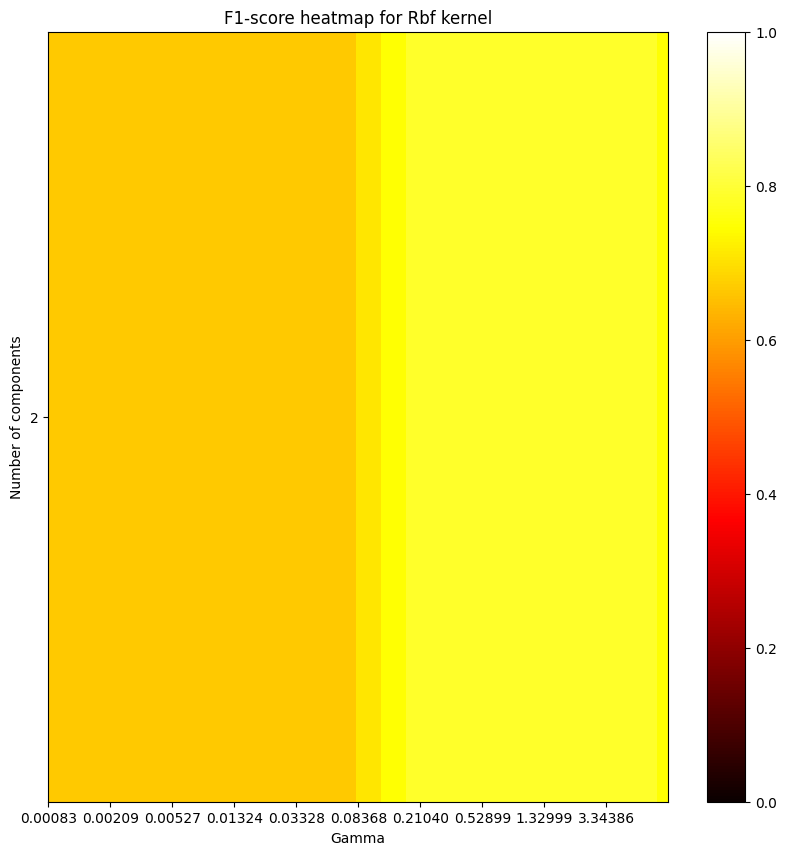

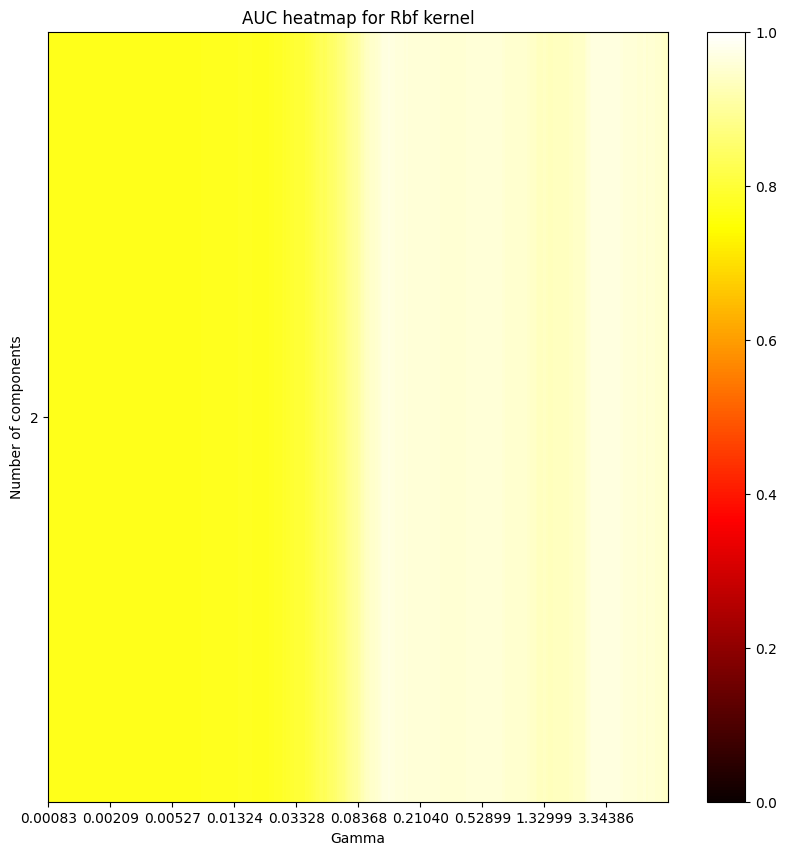

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

x_step_size = 100
y_step_size = 10

# Create arrays from the dictionaries for the 'rbf' kernel
f1_scores_array_rbf = np.array([[f1_scores.get(('rbf', n, g), 0) for g in gammas] for n in nn_components])
auc_scores_array_rbf = np.array([[auc_scores.get(('rbf', n, g),0) for g in gammas] for n in nn_components])

# Create arrays from the dictionaries for the 'poly' kernel
f1_scores_array_poly = np.array([[f1_scores.get(('poly', n, g), 0) for g in gammas] for n in nn_components])
auc_scores_array_poly = np.array([[auc_scores.get(('poly', n, g),0) for g in gammas] for n in nn_components])

# convert gammas to float format with 3 decimal places
formatted_gammas = ['{:.5f}'.format(gamma) for gamma in gammas]

plt.figure(figsize=(10,10))
plt.imshow(f1_scores_array_poly, cmap='hot', interpolation='nearest', aspect='auto', norm=colors.Normalize(vmin=0, vmax=1))
plt.title('F1-score heatmap for Poly kernel')
plt.xlabel('Gamma')
plt.ylabel('Number of components')
plt.xticks(range(0, len(formatted_gammas), x_step_size), formatted_gammas[::x_step_size])
plt.yticks(range(0, len(nn_components), y_step_size), nn_components[::y_step_size])
plt.colorbar()
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(auc_scores_array_poly, cmap='hot', interpolation='nearest', aspect='auto', norm=colors.Normalize(vmin=0, vmax=1))
plt.title('AUC heatmap for Poly kernel')
plt.xlabel('Gamma')
plt.ylabel('Number of components')
plt.xticks(range(0, len(formatted_gammas), x_step_size), formatted_gammas[::x_step_size])
plt.yticks(range(0, len(nn_components), y_step_size), nn_components[::y_step_size])
plt.colorbar()
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(f1_scores_array_rbf, cmap='hot', interpolation='nearest', aspect='auto', norm=colors.Normalize(vmin=0, vmax=1))
plt.title('F1-score heatmap for Rbf kernel')
plt.xlabel('Gamma')
plt.ylabel('Number of components')
plt.xticks(range(0, len(formatted_gammas), x_step_size), formatted_gammas[::x_step_size])
plt.yticks(range(0, len(nn_components), y_step_size), nn_components[::y_step_size])
plt.colorbar()
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(auc_scores_array_rbf, cmap='hot', interpolation='nearest', aspect='auto', norm=colors.Normalize(vmin=0, vmax=1))
plt.title('AUC heatmap for Rbf kernel')
plt.xlabel('Gamma')
plt.ylabel('Number of components')
plt.xticks(range(0, len(formatted_gammas), x_step_size), formatted_gammas[::x_step_size])
plt.yticks(range(0, len(nn_components), y_step_size), nn_components[::y_step_size])
plt.colorbar()
plt.show()
